Clone *NVIDIA* Repo with pretrained models

```shell
git clone https://github.com/NVIDIA/DeepLearningExamples.git
```

In [ ]:
import os
import sys

import tqdm

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.utils.data as td

from sklearn.preprocessing import LabelEncoder

sys.path += ["DeepLearningExamples/PyTorch/SpeechRecognition/QuartzNet"]

In [2]:
df = pd.read_csv("data/youtube.csv").drop_duplicates("link")

<AxesSubplot:ylabel='category'>

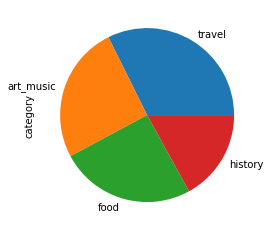

In [3]:
df.category.value_counts().plot.pie()

### Load pretrained model

In [4]:
from quartznet.model import QuartzNet
from quartznet.config import load, encoder, decoder, input as inp


DEVICE = "cuda:0"

cfg = load("DeepLearningExamples/PyTorch/SpeechRecognition/QuartzNet/configs/quartznet15x5_speedp-online-1.15_speca.yaml")
enc = encoder(cfg)
dec = decoder(cfg, n_classes=29)

net = QuartzNet(enc, dec)

/bin/sh: 1: sox: not found
SoX could not be found!

    If you do not have SoX, proceed here:
     - - - http://sox.sourceforge.net/ - - -

    If you do (or think that you should) have SoX, double-check your
    path variables.
    


In [5]:
state_dict = torch.load("pretrained/nvidia_quartznet_210504.pt")["ema_state_dict"]
net.load_state_dict(state_dict)
net = net.to(DEVICE).eval()

### Prepare *.wav* files for extracting embeddings

In [6]:
from common.dataset import FilelistDataset, get_data_loader

root  = "data/wavs"
files = [f"{root}/{file}" for file in os.listdir(root)]

with open("data/pathes.txt", "w") as f:
    f.write("\n".join(files))

In [7]:
import torch
import torch.utils.data as td

In [8]:
def collate_fn(batch):
    bs      = len(batch)
    max_len = lambda l, idx: max(el[idx].size(0) for el in l)
    audio   = torch.zeros(bs, max_len(batch, 0))
    audio_lens = torch.zeros(bs, dtype=torch.int32)
    transcript = torch.zeros(bs, max_len(batch, 2))
    transcript_lens = torch.zeros(bs, dtype=torch.int32)

    for i, sample in enumerate(batch):
        audio[i].narrow(0, 0, sample[0].size(0)).copy_(sample[0])
        audio_lens[i] = sample[1]
        transcript[i].narrow(0, 0, sample[2].size(0)).copy_(sample[2])
        transcript_lens[i] = sample[3]
        
    return audio, audio_lens, transcript, transcript_lens

dataset = FilelistDataset("data/pathes.txt")
loader  = td.DataLoader(dataset, batch_size=16, collate_fn=collate_fn, shuffle=False)

### Extract embeddings from QuarzNet model and average them by frame

In [9]:
# import tqdm
# import numpy as np
# from common.features import FilterbankFeatures

# embeddings = []

# _, features_kw = inp(cfg, "val")
# feat_proc      = FilterbankFeatures(**features_kw).to(DEVICE)

# for it, batch in enumerate(tqdm.tqdm(loader)):
#     batch = [t.to(DEVICE) for t in batch]
#     audio, audio_lens, _, _ = batch
#     feats, feat_lens = feat_proc(audio, audio_lens)
    
#     with torch.no_grad():
#         [frame_emb], _ = net.encoder(feats, feat_lens)
#         embedding      = frame_emb.mean(dim=2)
#         embeddings.append(embedding.cpu().numpy())
        
# embeddings = np.concatenate(embeddings)
# np.save("embeddings.npy", embeddings)

embeddings = np.load("embeddings.npy")

### Define dataset torch compatible class

In [10]:
class Subset(td.Dataset):
    def __init__(self, dataset, indices):
        self.dataset = dataset
        self.indices = indices
    
    def __getitem__(self, index):
        return self.dataset[self.indices[index]]
    
    def __len__(self):
        return len(self.indices)


class YouTubeAudioDataset(td.Dataset):
    def __init__(self, embeddings, targets):
        assert len(embeddings) == len(targets)
        self.embedds = embeddings
        self.targets = targets
        self.encoder = LabelEncoder().fit(targets)
          
    @property
    def classes(self):
        return self.encoder.classes_
    
    @property
    def num_classes(self):
        return len(self.classes)
        
    def __getitem__(self, index):
        embed  = self.embedds[index]
        target = self.encoder.transform([self.targets[index]])[0]
        
        return embed, target
    
    def __len__(self):
        return len(self.targets)

### Stratified train / test split

In [11]:
file_ids = os.listdir(root)
file_ids = [f.split(".")[0] for f in file_ids]

targets  = [df[df.link == f]["category"].iloc[0] for f in file_ids]

youtube_dataset = YouTubeAudioDataset(embeddings, targets)

In [12]:
from sklearn.model_selection import train_test_split

train_indices, valid_indices = train_test_split(np.arange(len(youtube_dataset)), test_size=0.15, stratify=targets)

train_ds = Subset(youtube_dataset, train_indices)
valid_ds = Subset(youtube_dataset, valid_indices)

len(train_ds), len(valid_ds)

(1454, 257)

### Defina simple classifier neural network

In [13]:
class AudioClassifier(nn.Module):
    def __init__(self, embedding_size: int, num_classes: int, dropout: float = 0.5):
        super().__init__()
        self.fc   = nn.Linear(embedding_size, 256)
        self.tanh = nn.Tanh()
        self.drop = nn.Dropout(p=dropout)
        self.head = nn.Linear(256, num_classes)
    
    def forward(self, x):
        x = self.fc(x)
        x = self.tanh(x)
        x = self.drop(x)
        x = self.head(x)
        
        return x

In [14]:
classifier = AudioClassifier(
    embedding_size=1024, 
    num_classes=youtube_dataset.num_classes,
    dropout=0.85
).to(DEVICE)

train_loader = td.DataLoader(train_ds, batch_size=128, shuffle=True)
valid_loader = td.DataLoader(valid_ds, batch_size=128)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(classifier.parameters(), lr=1e-4, weight_decay=1e-2)  

In [15]:
epochs   = 1000
log_freq = 50

for e in range(epochs):
    
    train_loss = 0
    valid_loss = 0
    
    classifier.train()
    for batch in train_loader:
        optimizer.zero_grad()
        
        x, y   = [t.to(DEVICE) for t in batch]
        logits = classifier(x)
        loss   = criterion(logits, y)
        
        loss.backward()
        optimizer.step()
        
        train_loss += loss.detach().cpu().item()
        
    classifier.eval()
    for batch in valid_loader:
        x, y  = [t.to(DEVICE) for t in batch]
        
        with torch.no_grad():
            logits = classifier(x)
        loss = criterion(logits, y)
        valid_loss += loss.detach().cpu().item()
    
    if e % log_freq == 0 and e != 0:
        print(f"Epoch {e} / {epochs} finished")
        print(f"train loss: {(train_loss / len(train_loader)):.4f}, valid loss: {(valid_loss / len(valid_loader)):.4f}")

Epoch 50 / 1000 finished
train loss: 1.0359, valid loss: 1.0082
Epoch 100 / 1000 finished
train loss: 0.9920, valid loss: 0.9217
Epoch 150 / 1000 finished
train loss: 0.9721, valid loss: 0.8793
Epoch 200 / 1000 finished
train loss: 0.9521, valid loss: 0.8336
Epoch 250 / 1000 finished
train loss: 0.9383, valid loss: 0.8042
Epoch 300 / 1000 finished
train loss: 0.9431, valid loss: 0.7876
Epoch 350 / 1000 finished
train loss: 0.9157, valid loss: 0.7699
Epoch 400 / 1000 finished
train loss: 0.9138, valid loss: 0.7573
Epoch 450 / 1000 finished
train loss: 0.8796, valid loss: 0.7465
Epoch 500 / 1000 finished
train loss: 0.8868, valid loss: 0.7344
Epoch 550 / 1000 finished
train loss: 0.8901, valid loss: 0.7128
Epoch 600 / 1000 finished
train loss: 0.8883, valid loss: 0.7197
Epoch 650 / 1000 finished
train loss: 0.8890, valid loss: 0.7015
Epoch 700 / 1000 finished
train loss: 0.8641, valid loss: 0.6952
Epoch 750 / 1000 finished
train loss: 0.8851, valid loss: 0.6956
Epoch 800 / 1000 finished


In [16]:
true = []
pred = []

classifier.eval()

for batch in valid_loader:
    x, y  = [t.to(DEVICE) for t in batch]
        
    with torch.no_grad():
        logits  = classifier(x)
        classes = logits.argmax(dim=1)
    
    true.append(y.cpu().numpy())
    pred.append(classes.cpu().numpy())
    
true = np.concatenate(true)
pred = np.concatenate(pred)

In [17]:
from sklearn.metrics import f1_score, recall_score, precision_score, confusion_matrix, ConfusionMatrixDisplay

f1_score(true, pred, average="macro"), precision_score(true, pred, average="macro"), recall_score(true, pred, average="macro")

(0.7123493329221111, 0.721067053513862, 0.721067053513862)

In [18]:
(true == pred).mean()

0.7003891050583657

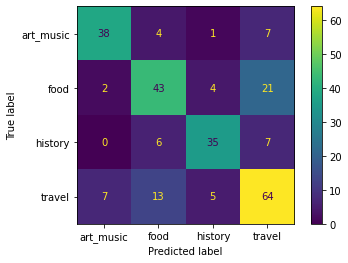

In [19]:
m = confusion_matrix(true, pred)

ConfusionMatrixDisplay(m, display_labels=youtube_dataset.classes).plot()